In [1]:
import tensorflow as tf
tf.__version__, tf.test.is_built_with_cuda(), tf.test.is_gpu_available()

('2.0.0-beta1', True, True)

In [2]:
%run ~/common_init.py
import flamedisx as fd
import tensorflow as tf
fd.float_type()

Active python: /home/aalbers/miniconda3/envs/py36/bin/python


tf.float32

In [3]:
rn_data = pd.read_csv('data_Rn220_lowenergy.csv')[::4]
fd.SR0ERSource.annotate_data(rn_data)
rn_data = rn_data[rn_data['e_vis'] < 10].copy()
rn_data = rn_data[['s1', 's2'] + ['x_observed', 'y_observed', 'x', 'y', 'z', 'drift_time']]

In [4]:
len(rn_data)

163

In [5]:
rn_data = rn_data.iloc[:160]

In [6]:
len(rn_data)

160

In [7]:
ll = fd.LogLikelihood(
    sources=dict(er=fd.SR0ERSource),
    batch_size=40 if tf.test.is_gpu_available() else 10,
    free_rates='er',
    data=rn_data,
    elife=(300e3, 500e3, 3),
    erqy_a=(5., 25., 2),
    erqy_b=(-29., -26., 2),
    erqy_c=(31.9, 32.8, 2),
    g2=(25., 35., 2),
    n_trials=int(2e5))
len(rn_data), len(rn_data) / ll.mu_itps['er']().numpy()

Estimating mus: 100%|██████████| 5/5 [00:20<00:00,  4.23s/it]


(160, 0.18461574432623712)

W0716 06:50:48.888022 140390298163008 deprecation.py:323] From /home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/tensorflow_probability-0.7.0-py3.6.egg/tensorflow_probability/python/math/interpolation.py:126: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


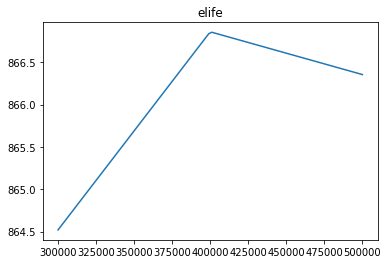

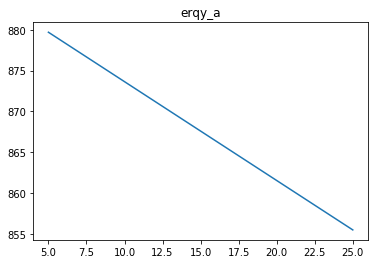

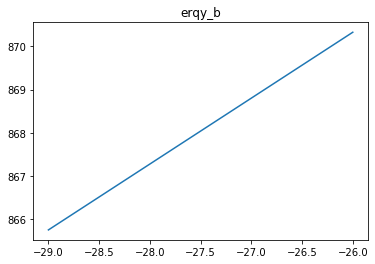

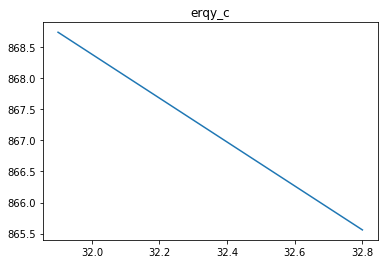

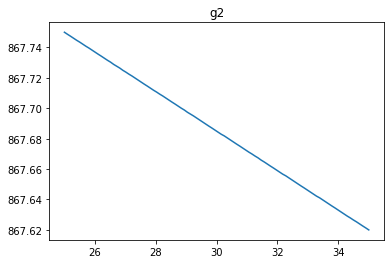

In [8]:
for pname in ll.param_names:
    if pname.endswith('_rate_multiplier'):
        continue
    start, stop, n = ll.param_specs[pname]
    x = np.linspace(start, stop, 100, dtype=np.float32)
    y = np.array([ll.mu_itps['er'](**{pname: tf.constant(q)}) for q in x])
    plt.plot(x, y)
    plt.title(pname)
    plt.show()

In [9]:
guess = ll.guess().numpy()
guess[0] = 0.02 * 4

In [10]:
# This ensures all graphs are traced and the benchmark below is accurate
bestfit = ll.bestfit(guess)

In [11]:
%%time
bestfit = ll.bestfit(guess)

CPU times: user 18.2 s, sys: 912 ms, total: 19.1 s
Wall time: 36.4 s


In [12]:
%%time
inv_hess = ll.inverse_hessian(bestfit)

Computing hessian: 100%|██████████| 4/4 [00:40<00:00, 10.37s/it]

CPU times: user 29.1 s, sys: 4.85 s, total: 33.9 s
Wall time: 40.9 s


In [13]:
ll.summary(bestfit, inverse_hessian=inv_hess)

er_rate_multiplier: 0.186 +- 0.0104
elife: 4.92e+05 +- 1.57e+04
erqy_a: 25 +- 6.05
erqy_b: -23.6 +- 1.52
erqy_c: 30.4 +- 0.659
g2: 31.4 +- 0.401
Correlation matrix:
                    er_rate_multiplier  elife     erqy_a     erqy_b  erqy_c  \
er_rate_multiplier           1.000e+00  0.002 -2.555e-04  3.410e-04  -0.001   
elife                        1.627e-03  1.000 -1.541e-01  2.053e-01  -0.676   
erqy_a                      -2.555e-04 -0.154  1.000e+00  3.143e-01  -0.315   
erqy_b                       3.410e-04  0.205  3.143e-01  1.000e+00  -0.444   
erqy_c                      -1.144e-03 -0.676 -3.154e-01 -4.435e-01   1.000   
g2                          -6.081e-05 -0.103 -2.771e-02  4.210e-02  -0.333   

                           g2  
er_rate_multiplier -6.081e-05  
elife              -1.028e-01  
erqy_a             -2.771e-02  
erqy_b              4.210e-02  
erqy_c             -3.332e-01  
g2                  1.000e+00  


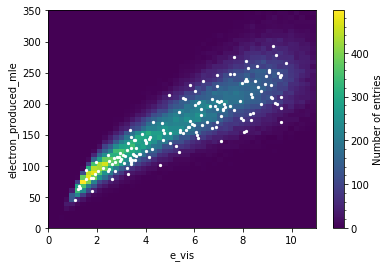

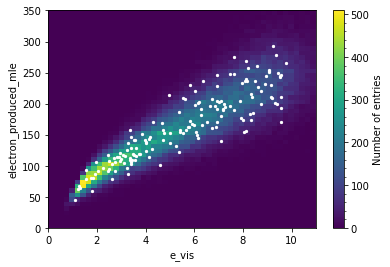

In [14]:
n_trials = int(1e5)

sim_guess = fd.SR0ERSource.simulate(
    n_trials, 
    data=rn_data,
    **ll.params_to_dict(guess))

sim_bf = fd.SR0ERSource.simulate(
    n_trials, 
    data=rn_data,
    **ll.params_to_dict(bestfit.numpy()))

bins = np.linspace(0, 11, 10)
for d_sim in sim_guess, sim_bf:
    Histdd(d_sim, dimensions=(
        ('e_vis', np.linspace(0, 11, 50)),
        ('electron_produced_mle', np.linspace(0, 350, 50)),
    )).plot()
    d = rn_data
    plt.scatter(d['e_vis'], d['electron_produced_mle'], c='white', s=5)
    plt.show()
